In [1]:

!pip install fastai
!pip install timm

In [2]:
from fastai.vision.all import *

/home/dnth/anaconda3/envs/timm-edge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
trn_path = Path('../data/train_images')

In [4]:
dls = ImageDataLoaders.from_folder(trn_path, seed=316, valid_pct=0.2, 
                                item_tfms=[Resize((224, 224))], 
                                batch_tfms=aug_transforms(min_scale=0.75))


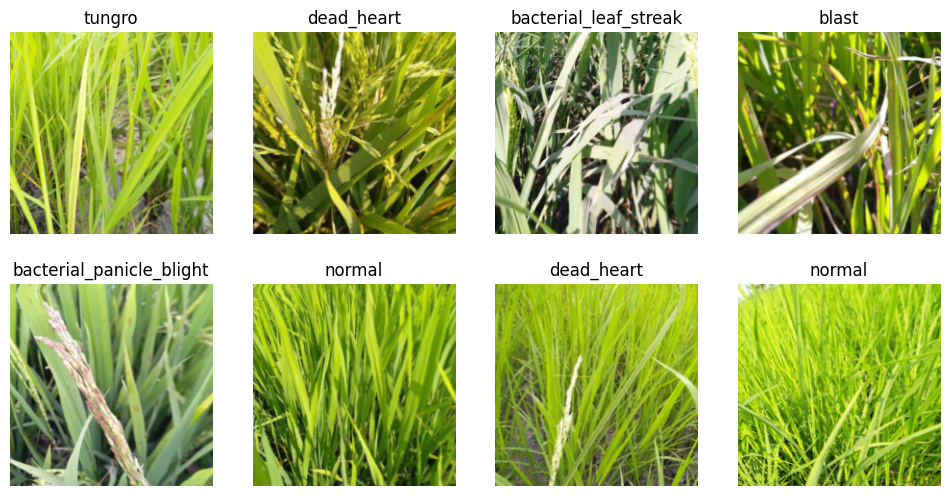

In [5]:
dls.train.show_batch(max_n=8, nrows=2)

In [6]:
import timm
timm.list_models('*edge*')

['cs3edgenet_x',
 'cs3se_edgenet_x',
 'edgenext_base',
 'edgenext_small',
 'edgenext_small_rw',
 'edgenext_x_small',
 'edgenext_xx_small']

In [7]:
learn = vision_learner(dls, 'edgenext_small', metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.001737800776027143)

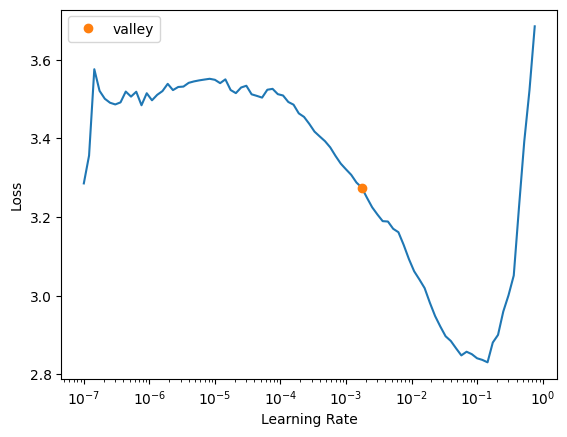

In [8]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.578078,1.427991,0.624700,00:27


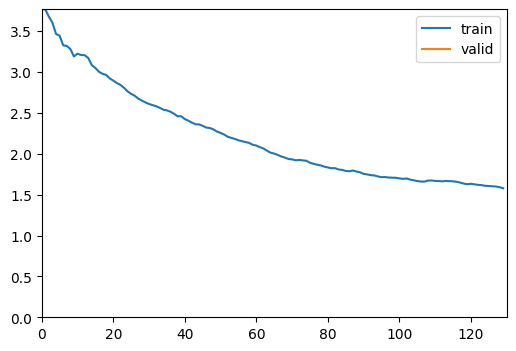

epoch,train_loss,valid_loss,accuracy,time
0,0.977052,0.673517,0.773186,00:29
1,0.796309,0.495838,0.841903,00:27
2,0.583058,0.415917,0.867371,00:28
3,0.429631,0.326354,0.895243,00:28
4,0.391470,0.312346,0.899087,00:29


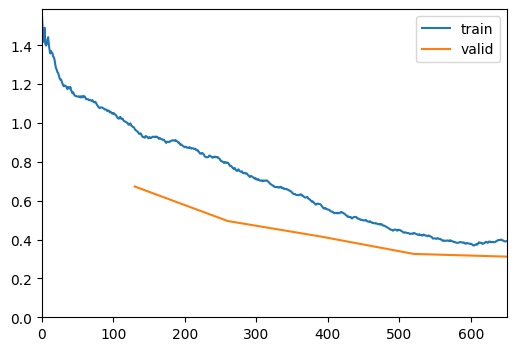

In [9]:
learn.fine_tune(5, base_lr=1e-2, cbs=[ShowGraphCallback()])

In [10]:
learn.export("../../train/export.pkl")

In [11]:
import torch
from torch.utils.mobile_optimizer import optimize_for_mobile

learn.model.cpu()
learn.model.eval();
example = torch.rand(1, 3, 224, 224)
traced_script_module = torch.jit.trace(learn.model, example)
optimized_traced_model = optimize_for_mobile(traced_script_module)
optimized_traced_model._save_for_lite_interpreter("model.pt")